In [2]:
import sys
import os
from pathlib import Path
sys.path.append(
    os.path.dirname(os.path.abspath('.'))
)
from src import QNet, agent_metrics, show_reward, settings
### path load

import numpy as np
import torch
from torchvision import datasets
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from blur_funcs import FUNCS_GR, ACTIONS_GR, FUNCS_RN, ACTIONS_RN

SEED = 0
device = 'cuda:0'

2 channel weight: =  0.05
RESULT_PATH results/RN/train_gauss/channel02_weight005_seed00


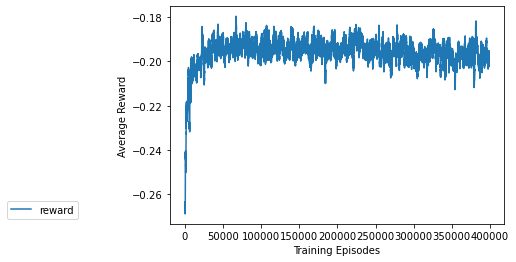

test func gauss
TEST_DATASET_PATH data/GR/test/gauss/c3_dataset.npz
MSE(test_dataset, agent_outputs) =  0.04175400990559583
test func random
TEST_DATASET_PATH data/GR/test/random/c3_dataset.npz
MSE(test_dataset, agent_outputs) =  0.0460259934357729
test func smooth
TEST_DATASET_PATH data/GR/test/smooth/c3_dataset.npz
MSE(test_dataset, agent_outputs) =  0.047281997864820596


In [11]:
# 実験条件を指定
ACTIONS_TYPE = 'RN'
SEED = 0
#TR_C = 3
TST_C = 3
for setting_num in [4]:
    setting = getattr(settings, f'setting{setting_num}')
    CHANNEL = setting.CHANNEL
    WEIGHT = setting.WEIGHT
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = os.path.join(
        'results/%s/train_gauss/' % (ACTIONS_TYPE,),
        'channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED)
    )
    print("RESULT_PATH", RESULT_PATH)

    actions = [lambda x: x] + ACTIONS_RN

    # see reward
    ax = plt.subplot(111)
    ma = show_reward(ax, dir_path=RESULT_PATH, mono=False, n=1000, label='reward')
    plt.show()

    for TEST_FUNC in ['gauss', 'random', 'smooth']:
        print('test func', TEST_FUNC)
        # load test data
        TEST_DATASET_PATH = 'data/GR/test/%s/c%d_dataset.npz' % (TEST_FUNC, TST_C)
        print("TEST_DATASET_PATH", TEST_DATASET_PATH)
        test_dataset_context = np.load(TEST_DATASET_PATH)
        originals = test_dataset_context['original_dataset']
        test_dataset = test_dataset_context['test_dataset']

        mse = np.mean((test_dataset - originals)**2)
        print('MSE(test_dataset, agent_outputs) = ', mse)

2 channel weight: =  0.05
RESULT_PATH results/RN/train_gauss/channel02_weight005_seed00


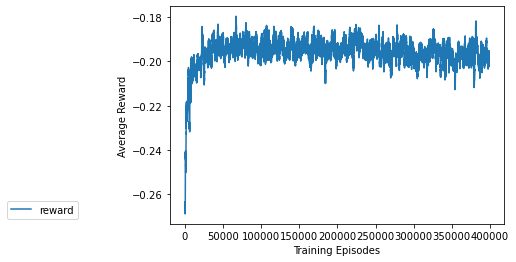

test func gauss
TEST_DATASET_PATH data/GR/test/gauss/c3_dataset.npz
MODEL_PATH results/RN/train_gauss/channel02_weight005_seed00/Qnet020000.pth



MSE(test_dataset, agent_outputs) =  0.05905598585382104
action frequency
0 (array([0.019 , 0.9721, 0.    , 0.0089, 0.    ]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))
1 (array([0.0196, 0.9721, 0.    , 0.0083, 0.    ]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))
2 (array([0.0217, 0.9716, 0.    , 0.0067, 0.    ]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))
3 (array([2.670e-02, 9.672e-01, 1.000e-04, 6.000e-03, 0.000e+00]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))
4 (array([3.620e-02, 9.591e-01, 2.000e-04, 4.500e-03, 0.000e+00]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))

METRIC_PATH results/RN/train_gauss/channel02_weight005_seed00/metricsgauss_059
--------------------

test func random
TEST_DATASET_PATH data/GR/test/random/c3_dataset.npz
MODEL_PATH results/RN/train_gauss/channel02_weight005_seed00/Qnet020000.pth



MSE(test_dataset, agent_outputs) =  0.06016822845879942
action frequency
0 (array([0.017 , 0.9677, 0.    , 0.0153, 0.    ]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))
1 (array([0.0182, 0.968 , 0.    , 0.0138, 0.    ]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))
2 (array([0.0199, 0.969 , 0.    , 0.0111, 0.    ]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))
3 (array([0.0234, 0.9662, 0.    , 0.0104, 0.    ]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))
4 (array([3.440e-02, 9.574e-01, 4.000e-04, 7.800e-03, 0.000e+00]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))

METRIC_PATH results/RN/train_gauss/channel02_weight005_seed00/metricsrandom_060
--------------------

test func smooth
TEST_DATASET_PATH data/GR/test/smooth/c3_dataset.npz
MODEL_PATH results/RN/train_gauss/channel02_weight005_seed00/Qnet020000.pth



MSE(test_dataset, agent_outputs) =  0.06070737403137609
action frequency
0 (array([0.0144, 0.9729, 0.    , 0.0127, 0.    ]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))
1 (array([0.0157, 0.9725, 0.    , 0.0118, 0.    ]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))
2 (array([0.0165, 0.9737, 0.    , 0.0098, 0.    ]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))
3 (array([1.940e-02, 9.717e-01, 1.000e-04, 8.800e-03, 0.000e+00]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))
4 (array([2.480e-02, 9.677e-01, 5.000e-04, 7.000e-03, 0.000e+00]), array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))

METRIC_PATH results/RN/train_gauss/channel02_weight005_seed00/metricssmooth_060
--------------------



In [12]:
# 実験条件を指定
ACTIONS_TYPE = 'RN'
SEED = 0
#TR_C = 3
TST_C = 3
for setting_num in [4]:
    setting = getattr(settings, f'setting{setting_num}')
    CHANNEL = setting.CHANNEL
    WEIGHT = setting.WEIGHT
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = os.path.join(
        'results/%s/train_gauss/' % (ACTIONS_TYPE,),
        'channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED)
    )
    print("RESULT_PATH", RESULT_PATH)

    actions = [lambda x: x] + ACTIONS_RN

    # see reward
    ax = plt.subplot(111)
    ma = show_reward(ax, dir_path=RESULT_PATH, mono=False, n=1000, label='reward')
    plt.show()

    for TEST_FUNC in ['gauss', 'random', 'smooth']:
        print('test func', TEST_FUNC)
        # load test data
        TEST_DATASET_PATH = 'data/GR/test/%s/c%d_dataset.npz' % (TEST_FUNC, TST_C)
        print("TEST_DATASET_PATH", TEST_DATASET_PATH)
        test_dataset_context = np.load(TEST_DATASET_PATH)
        originals = test_dataset_context['original_dataset']
        test_dataset = test_dataset_context['test_dataset']
        test_dataset = torch.from_numpy(test_dataset).to(torch.float32)
        originals = torch.from_numpy(originals).to(torch.float32)

        # load model
        Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
        MODEL_PATH = os.path.join(RESULT_PATH, 'Qnet020000.pth')
        print('MODEL_PATH', MODEL_PATH)
        Qnet.load_state_dict(
            torch.load(MODEL_PATH)
        )
        result = agent_metrics(test_dataset, originals, Qnet, actions, channel=CHANNEL)
        mse = result[:, -1].mean()
        print('MSE(test_dataset, agent_outputs) = ', mse)
        print('action frequency')
        for j in range(5):
            print(j, np.histogram(result[:, j], bins=np.arange(6) - 0.5, density=True))
        print()

        METRIC_PATH = os.path.join(RESULT_PATH, f'metrics{TEST_FUNC}_{int(1000*mse):03d}')
        print("METRIC_PATH", METRIC_PATH)
        np.save(METRIC_PATH, result)
        print('-' * 20)
        print()

In [3]:
setting_num = 1
ACTIONS_TYPE = 'GR'
SEED = 0
setting = getattr(settings, f'setting{setting_num}')
CHANNEL = setting.CHANNEL
WEIGHT = setting.WEIGHT
print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
RESULT_PATH = os.path.join(
    'results/%s/train_gauss/' % (ACTIONS_TYPE,),
    'channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED)
)
print("RESULT_PATH", RESULT_PATH)

1 channel weight: =  0.0
RESULT_PATH results/GR/train_gauss/channel01_weight000_seed00


In [13]:
CHANNEL, WEIGHT = 1, 0.00
RESULT_PATH = os.path.join(
    'results/%s/train_gauss/' % (ACTIONS_TYPE,),
    'channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED)
)
METRIC_PATH = Path(RESULT_PATH)
p = list(METRIC_PATH.glob('metricsgauss*'))[0]
result = np.load(str(p))
np.histogram(result[:, :-1].ravel(), bins=np.arange(6) - 0.5)

(array([   79, 16192, 33729,     0,     0]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))